In [96]:
#data manipulation
import copy
import math
import numpy as np
import pandas as pd
import random


#probability mass function generator
import lifelines as ln
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess

#simulation
import ciw

#dataviz
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
warnings.filterwarnings('ignore', category=DeprecationWarning, module='seaborn')

In [97]:
class Customer:
    """customer class consists of name, the expected arrival frequency, and the expected time to service a call of that customer type
    Customer objects will be inserted into the customer list to be used in standard_simulation()

    params:
    - customer_name: string, name of customer or call type
    - avg_time_between_arrivals: float, amount of time between arrivals. In the case of sequential distribution, this should be a list of time between each arrival
    - avg_service_time: float, length of time period per call (!!!this is not a rate and will be converted at get_customer_distributions()!!!)
    - arrival_distribution_type: string, distribution that Ciw will use. 'Exponential' is default, can also be 'Deterministic' (value will always be avg_time_between_arrivals), or 'Sequential' (not recommended)
    - service_distribution_type: string, distribution that Ciw will use. 'Exponential' is default, can also be 'Deterministic' (value will always be avg_service_time), or 'Sequential' (not recommended)"Exponential"
    - reneging_time: float, default None, amount of time before customer will wait before hanging up if not answered (!!!this is not a rate and will be converted at get_customer_distributions()!!!)
    - reneging_distribution_type: string, default 'Deterministic', can also be 'Exponential' 
    - priority: int, default 0, if more than one call is waiting when agent becomes available, which call does agent take (if no priority difference, agent takes call with earlier arrival time). 0 is highest priority, 1 next, then 2, etc.
    """
    def __init__(self, customer_name,avg_time_between_arrivals,avg_service_time,arrival_distribution_type="Exponential",service_distribution_type="Exponential", reneging_time=None, reneging_distribution_type='Deterministic', priority=0):
        self.customer_name = customer_name
        self.avg_time_between_arrivals = avg_time_between_arrivals
        self.avg_service_time = avg_service_time
        self.arrival_distribution_type = arrival_distribution_type
        self.service_distribution_type = service_distribution_type
        self.reneging_time = reneging_time
        self.reneging_distribution_type = reneging_distribution_type
        self.priority = priority
        self.cust_dists = self.get_customer_distributions()
        self.generalized_arrival_distribution = self.cust_dists['generalized_arrival_distribution']
        self.generalized_service_time_distribution = self.cust_dists['generalized_service_time_distribution']
        self.reneging_distribution = self.cust_dists['reneging_distribution']

    def get_customer_distributions(self):
        """creates ciw distributions for arrival rates, service times, and reneging times"""
    
        # Add more as required (sequential not currently used - if needed see simulate_alternate_scenario()
        distribution_mapping = {
            'Exponential': ciw.dists.Exponential,
            'Sequential': ciw.dists.Sequential,
            'Deterministic': ciw.dists.Deterministic
        }
    
        """Create arrival distribution"""
        if self.arrival_distribution_type == 'Exponential':
            arrival_rate = 1 / self.avg_time_between_arrivals
            generalized_arrival_distribution = distribution_mapping[self.arrival_distribution_type](rate=arrival_rate)
        elif self.arrival_distribution_type == 'Sequential':
            generalized_arrival_distribution = distribution_mapping[self.arrival_distribution_type](sequence=self.avg_time_between_arrivals)
        elif self.arrival_distribution_type == 'Deterministic':
            generalized_arrival_distribution = distribution_mapping[self.arrival_distribution_type](value=self.avg_time_between_arrivals)

    
        """Create service time distribution"""
        if self.service_distribution_type == 'Exponential':
            service_rate = 1 / self.avg_service_time
            generalized_service_time_distribution = distribution_mapping[self.service_distribution_type](rate=service_rate)
        elif self.service_distribution_type == 'Sequential':
            generalized_service_time_distribution = distribution_mapping[self.service_distribution_type](sequence=self.avg_service_time)
        elif self.service_distribution_type == 'Deterministic':
            generalized_service_time_distribution = distribution_mapping[self.service_distribution_type](value=self.avg_service_time)
    
        """Create reneging time distribution"""
        if self.reneging_time:
            if self.reneging_distribution_type == 'Exponential':
                reneging_rate = 1/self.reneging_time
                reneging_distribution = distribution_mapping[self.reneging_distribution_type](rate=reneging_rate)
            elif self.reneging_distribution_type == 'Sequential':
                reneging_distribution = distribution_mapping[self.reneging_distribution_type](sequence=self.reneging_time)
            elif self.reneging_distribution_type == 'Deterministic':
                reneging_distribution = distribution_mapping[self.reneging_distribution_type](value=self.reneging_time)
        else:
            reneging_distribution = ciw.dists.Deterministic(value=1000000000)

    
        customer_distributions= {
                'generalized_arrival_distribution': generalized_arrival_distribution,
                'generalized_service_time_distribution': generalized_service_time_distribution,
                'reneging_distribution': reneging_distribution
        }
            
        return customer_distributions


In [98]:
class CustomerEmpirical:
    """customer class consists of name, the expected arrival frequency, and the expected time to service a call of that customer type
    Customer objects will be inserted into the customer list to be used in standard_simulation()

    params:
    number_of_servers: int or list [[server count, end of scheduled time], [4, 25], [7 , 12], . . .].
    """
    def __init__(self, customer_name, dataframe, distribution_preference='historical', priority=0):
        self.customer_name = customer_name
        self.priority = priority
        self.data = dataframe
        self.attrs = self.get_historical_customer_attributes()
        self.avg_time_between_arrivals = self.attrs['avg_time_between_arrivals']
        self.avg_service_time = self.attrs['avg_service_time']
        self.reneging_distribution = self.attrs['reneging_distribution']
        self.historical_arrival_distribution = self.attrs['historical_arrival_distribution']
        self.generalized_arrival_distribution = self.attrs['generalized_arrival_distribution']
        self.historical_service_time_distribution = self.attrs['historical_service_time_distribution']
        self.generalized_service_time_distribution = self.attrs['generalized_service_time_distribution']
        self.distribution_preference = distribution_preference
        self.smoothed_reneging = None     


    """prepare the dataframe for calculating historical attributes"""
    def prep_dataframe(self):
        df = self.data
        df.request_timestamp = pd.to_datetime(df['request_timestamp'], errors='coerce',utc=True)
        df.pick_timestamp = pd.to_datetime(df['pick_timestamp'], errors='coerce',utc=True)
        df.end_timestamp = pd.to_datetime(df['end_timestamp'], errors='coerce',utc=True)

    
        #convert ellapsed time from request to end if cancel (end happens at time of cancelling), or request to pick if end (otherwise call length included)
        df['time'] = df.apply(lambda row: (row['pick_timestamp'] - row['request_timestamp']).total_seconds() if row['status'] == 'END' else (row['end_timestamp'] - row['request_timestamp']).total_seconds() if row['status'] == 'CANCEL' else pd.NaT, axis=1)
        #calculate call duration
        df['call_duration'] = np.where(df['status'] == 'END', (df['end_timestamp'] - df['pick_timestamp']).dt.total_seconds(), np.nan)
        #sort df by request_timestamp
        self.data = df.sort_values(by='request_timestamp', ascending=True, axis=0).reset_index(drop=True)
    
    """calculate the reneging distribution by creating a Kaplan-Meier curve, and using that to calculate the probability mass function for reneging. """
    def get_reneging_distribution(self):
        reneging_distribution = None

        df = self.data
        #set up KM
        kmf = ln.KaplanMeierFitter()
        #remove events that are throttled for this step to avoid Null in event
        df = df.loc[df['status'] != 'THROTTLED']
        time = df['time']
        event = df['status'].map({'END': 0, 'CANCEL': 1}).tolist()
        kmf.fit(time, event_observed = event)
        #kmf.survival_function_.plot() #maybe add this later if needed, otherwise just to check
        #create probability mass function for reneging
        pmf=kmf.survival_function_.copy()
        pmf['KM_estimate'] = 1 - pmf['KM_estimate']
        pmf['rate_of_change'] = pmf['KM_estimate'].diff().fillna(0)
    
        #applying smoothing
        smoothed = lowess(pmf['rate_of_change'], pmf.index, frac=0.15)
        smoothed_df = pd.DataFrame(smoothed, columns=['timeline', 'smoothed_rate'])
        
        # Interpolating to ensure we cover all original time points
        interpolator = interp1d(smoothed_df['timeline'], smoothed_df['smoothed_rate'], bounds_error=False, fill_value="extrapolate")
        pmf['smoothed_rate_of_change'] = interpolator(pmf.index)
        #bring all negative values from interpolation up to 0
        pmf['smoothed_rate_of_change'] = np.clip(pmf['smoothed_rate_of_change'], 0, None)
        #normalize sroc for prob mass function
        pmf['smoothed_rate_of_change'] = pmf['smoothed_rate_of_change']/pmf['smoothed_rate_of_change'].sum()
        # sns.lineplot(x=pmf.index,y=pmf['smoothed_rate_of_change'])

        # resample because ciw struggles with numerical precision for lists over 100
        min_index = pmf.index.min()
        top_quant_index = pd.Series(pmf.index).quantile(0.95)
        print(f'getting historical reneging distribution for {self.customer_name}')

        dist_creation_successful = False
        for sample_count in range(1000, 1, -1):
            
            try:
                resamp_time = np.linspace(min_index,top_quant_index, sample_count)
                
                resamp_rates = interpolator(resamp_time)
                resamp_rates = np.clip(resamp_rates,0,None)
                resamp_rates /= resamp_rates.sum()
                
                
                #convert to list because ciw can't use np.ndarray
                resamp_time = resamp_time.tolist()
                resamp_rates = resamp_rates.tolist()

                reneging_distribution = ciw.dists.Pmf(values=resamp_time, probs=resamp_rates)
                self.smoothed_reneging = [resamp_time, resamp_rates]
                print(f"distribution for {self.customer_name} created using {sample_count} samples")
                dist_creation_successful = True
                break
                
            # except ValueError as e:
            #     # keep for later debugging
            #     print(f"{sample_count} samples too high. Trying again with reduced samples. {e}")
            #     pass
            except:
                pass

        #distribution creation unsuccessful when no cancelled calls are present. Since no data is present, a substitution distribution will be created using 1.3x the max answer time
        if not dist_creation_successful:
            substitute_renege_avg = df['time'].max() * 1.3 
            reneging_distribution = ciw.dists.Exponential(rate=1/substitute_renege_avg)
            print(f"Renege distribution creation unsuccessful. Using Exponential fallback with rate {1/substitute_renege_avg}.")

        return reneging_distribution
        

    """This identifies the arrival frequency and creates a ciw distribution"""
    def get_generalized_arrival_distribution(self):
        
        df = self.data

        arrival_frequency = (df['request_timestamp'].max() - df['request_timestamp']).dt.total_seconds()
        avg_time_between_arrivals = ((df['request_timestamp'].max() - df['request_timestamp'].min())/len(df)).total_seconds() #time between arrivals
        avg_arrival_rate = 1 / avg_time_between_arrivals
    
        generalized_arrival_distribution = ciw.dists.Exponential(rate=avg_arrival_rate)
        return generalized_arrival_distribution, avg_time_between_arrivals


    """This provides a ciw distribution for historical (actual) arrival times based on the dataframe"""
    def get_historical_arrival_distribution(self):

        df = self.data

        historical_arrivals = (df['request_timestamp'] - min(df['request_timestamp'])).dt.total_seconds().reset_index(drop=True)
        inter_arrival_times = [historical_arrivals[i] - historical_arrivals[i - 1] for i in range(1, len(historical_arrivals))] #calculate length of time between arrivals for sequential distribution
        inter_arrival_times.insert(0, historical_arrivals[0] if historical_arrivals[0] > 0 else 0)
        historical_arrival_distribution = ciw.dists.Sequential(sequence = inter_arrival_times)

        return historical_arrival_distribution


    """This identifies how long serviced calls last and creates a ciw distribution"""
    def get_generalized_service_time_distribution(self):

        df = self.data
        
        service_times = df[df['status'] == "END"]['call_duration']
        avg_service_time = df[df['status'] == "END"]['call_duration'].mean()
        # #return avg_time_between_arrivals, avg_service_time, reneging_distribution
        
        generalized_service_time_distribution = ciw.dists.Empirical(observations=service_times)

        return generalized_service_time_distribution, avg_service_time
    
            
    """This provides a ciw distribution for historical (actual) service times based on the dataframe"""
    def get_historical_service_time_distribution(self):

        df = self.data
        
        historical_service_times = df.loc[df['status'] == 'END', 'call_duration']
        historical_service_time_distribution = ciw.dists.Sequential(sequence = historical_service_times)

        return historical_service_time_distribution

    
    """calculate all historical attributes at once"""
    def get_historical_customer_attributes(self):
        """uses dataframe to calculate historical customer class attributes
        Limiting the input data to certain times of day can help where day level seasonality is expected (e.g., B2B customers that only call from 9 – 5)"""

        self.prep_dataframe()

        reneging_distribution = self.get_reneging_distribution()

        generalized_arrival_distribution, avg_time_between_arrivals = self.get_generalized_arrival_distribution() 
        
        historical_arrival_distribution = self.get_historical_arrival_distribution()

        generalized_service_time_distribution, avg_service_time = self.get_generalized_service_time_distribution()

        historical_service_time_distribution = self.get_historical_service_time_distribution()


        attrs = {
            'avg_time_between_arrivals': avg_time_between_arrivals,
            'avg_service_time': avg_service_time,
            'reneging_distribution': reneging_distribution,
            'historical_arrival_distribution': [historical_arrival_distribution],
            'generalized_arrival_distribution': [generalized_arrival_distribution],
            'historical_service_time_distribution': [historical_service_time_distribution],
            'generalized_service_time_distribution': [generalized_service_time_distribution]
        }
       
        return attrs


In [99]:
def fill_null_with_distribution(dataframe):
    """The following is useful if the call type cannot be determined without succesfully connecting the call.
    It will randomly assign call type based on the distribution of known calls.
    WARNING: this can drastically influence the simulation in an unrealistic fashion, and should be avoided if at all possible"""
    counts_df = dataframe.dropna().groupby(['userid', 'call_category']).size().reset_index(name='count')
    total_counts_per_user = counts_df.groupby('userid')['count'].sum().reset_index(name='total_count')
    counts_df = counts_df.merge(total_counts_per_user, on='userid')
    counts_df['distribution'] = counts_df['count'] / counts_df['total_count']
    # Calculate the global distribution as a fallback
    global_counts = dataframe['call_category'].value_counts(normalize=True)

    def fill_null_based_on_distribution(row):
        if pd.isnull(row['call_category']):
            user_distributions = counts_df[counts_df['userid'] == row['userid']]
            if not user_distributions.empty:
                categories = user_distributions['call_category'].tolist()
                probabilities = user_distributions['distribution'].tolist()
                return np.random.choice(categories, p=probabilities)
            else:
                    # Use the global distribution as a fallback
                 return np.random.choice(global_counts.index, p=global_counts.values)
        return row['call_category']

    # Corrected: Apply the function using dataframe
    dataframe['call_category'] = dataframe.apply(fill_null_based_on_distribution, axis=1)
    
    return dataframe

In [100]:
def create_agent_schedule(agent_schedule,simulation_window, buffer_length, buffer_pre_servers=None, buffer_post_servers=None, schedule_units='seconds'):
    """changes agent schedule into ciw schedule object"""
    #create the schedule for agents before and after the sim window (during buffer periods)
    if buffer_pre_servers:
        prepend = [buffer_pre_servers, buffer_length]
    else:
        prepend = [agent_schedule[0][0], buffer_length]

    if buffer_post_servers:
        postpend = [buffer_post_servers, 2*buffer_length + simulation_window]
    else:
        postpend = [agent_schedule[-1][0], 2*buffer_length + simulation_window]

    full_schedule = copy.deepcopy(agent_schedule)

    #adjust the full schedule forward by the buffer length
    for i in full_schedule:
        i[1] = i[1]+buffer_length

    #add in the buffer scheduled agents
    full_schedule.insert(0,prepend)
    full_schedule.append(postpend)

    #change seconds to hours if needed
    unit_conversion = {'seconds': 1, 'minutes': 60, 'hours': 3600}.get(schedule_units, 1)
    for shift in full_schedule:
        shift[1] = shift[1]*unit_conversion

    sim_schedule = ciw.Schedule(schedule=full_schedule)

    return sim_schedule


In [101]:
#### TODO add ability to show concurrency per customer type


def calculate_concurrency(df, full_simulation_length):
    """Calculates the concurrency (number of agents in call at the same time) of a given time period of the simulation.
    A note on concurrency: can be higher than staffed agents at the time if agent from previous staffing stuck on longer call 
    (e.g., at 3:00 - 4:00, 3 agents are staffed, but 3:00 - 3:15 has concurrency 4 due to agent who would have gotten off at 3:00 staying to complete call)"""
    #prepare the df by renaming columns, rounding to nearest second, removing reneging calls
    working_df = df.copy()
    working_df['service_start_date'] = working_df['service_start_date'].round()
    working_df['service_end_date'] = working_df['service_end_date'].round()
    working_df = working_df[working_df['record_type'] != 'renege']
        
    events = []

    # Populate the events list with (time, type) tuples
    for index, row in working_df.iterrows():
        events.append((row['service_start_date'], 'start'))
        events.append((row['service_end_date'], 'end'))

    # Sort the events: first by time, then end events before start events at the same time
    events.sort(key=lambda x: (x[0], x[1] == 'start'))

    # Create an array for each time unit from min_time to max_time
    time_range = np.arange(0, full_simulation_length + 1)  # +1 to include the last end time
    concurrency_levels = np.zeros(len(time_range))

    # Initialize the current concurrency counter
    current_concurrency = 0

    # Traverse the event list and calculate concurrency
    for event in events:
        event_time, event_type = event
        if event_type == 'start':
            concurrency_levels[int(event_time)] += 1
        else:
            concurrency_levels[int(event_time)] -= 1

    # Compute the cumulative concurrency at each time unit
    np.cumsum(concurrency_levels, out=concurrency_levels)

    concurrency_df = pd.DataFrame({
        'time': time_range,
        'concurrency': concurrency_levels.astype(int)
    })
    
    # Create a DataFrame from the concurrency levels
    return concurrency_df


In [102]:
def calculate_waterfall(df, plot_window_start, plot_window_end,call_type=None, plot_units='seconds',order_by_type=False,ax=None):
    """Graph calls which overlap the window."""
        #filter to show only calls of a specific type(s)
    if call_type:
        if isinstance(call_type, list):
            df = df[df['customer_class'].isin(call_type)]
        else:
            df = df[df['customer_class'] == call_type]
    
    # Filter calls based on the given window
    df = df.copy()
    if order_by_type:
        df = df[(df['arrival_date'] < plot_window_end) & (df['exit_date'] > plot_window_start)].sort_values(by=['customer_class', 'arrival_date']).reset_index(drop=True)
    else:
        df = df[(df['arrival_date'] < plot_window_end) & (df['exit_date'] > plot_window_start)].sort_values(by='arrival_date').reset_index(drop=True)

    unit_name = plot_units
    unit_conversion = {'seconds': 1, 'minutes': 60, 'hours': 3600}.get(plot_units, 1)
    #also normalizing to plot window start = 0
    df['arrival_date'] = (df['arrival_date'] - plot_window_start) / unit_conversion
    df['service_start_date'] = (df['service_start_date'] - plot_window_start) / unit_conversion
    df['exit_date'] = (df['exit_date'] - plot_window_start) / unit_conversion
    plot_window_end = (plot_window_end - plot_window_start)/ unit_conversion
    plot_window_start = 0
  
    # Setup the plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 10))
    else:
        fig = ax.figure

    # Define a saturated color palette
    unique_classes = df['customer_class'].dropna().unique()
    palette = sns.color_palette("Set1", n_colors=len(unique_classes))
    color_dict = {cls: (mcolors.to_rgba(palette[i], alpha=0.4), palette[i]) for i, cls in enumerate(unique_classes)}

    # Plot each call from the DataFrame
    for i, row in df.iterrows():
        req, start, end, cust_class = row['arrival_date'], row['service_start_date'], row['exit_date'], row['customer_class']
        waiting_color, call_color = color_dict.get(cust_class, ('grey', 'black'))

        if pd.notna(start):
            # Plot waiting period
            ax.broken_barh([(req, start - req)], (i * 10, 9), facecolors=waiting_color)
            # Plot call period
            ax.broken_barh([(start, end - start)], (i * 10, 9), facecolors=call_color)
        else:
            # Plot extended waiting period if start is None
            ax.broken_barh([(req, end - req)], (i * 10, 9), facecolors=waiting_color)

    # Add vertical dashed lines at the start and end of the plot window
    ax.axvline(x=plot_window_start, color='black', linestyle='--', label='Window Start')
    ax.axvline(x=plot_window_end, color='black', linestyle='--', label='Window End')

    # Set labels and titles
    ax.set_xlabel(unit_name.capitalize())
    ax.set_ylabel('Calls')
    ax.set_title('Call Durations and Waiting Times')

    legend_ax = ax.inset_axes([0.01, 0.7, 0.2, 0.25],zorder=7)  # Adjust the position and size as needed
    # legend_ax.axis('off')  # Turn off the axis
    legend_ax.set_facecolor('white')  # Set the background color to white
    legend_ax.patch.set_alpha(1)  # Set opacity to 1 (fully opaque)
    legend_ax.set_xticks([])
    legend_ax.set_yticks([])

    # Add a solid background rectangle with a border that covers all text and bars
    # rect = mpatches.Rectangle((-0.1, -0.1), 1.2, 1.2,color='blue', transform=legend_ax.transAxes, edgecolor='black', linewidth=1, zorder=1)
    # legend_ax.add_patch(rect)
  
    for i, cls in enumerate(unique_classes):
        legend_ax.broken_barh([(0, 0.5), (0.5, 0.5)], (i * 1, 0.9), facecolors=[color_dict[cls][0], color_dict[cls][1]])
        legend_ax.text(1.1, i + 0.45, cls, va='center', zorder=7,bbox=dict(facecolor='white', edgecolor='none', pad=2))
    
    # Add "Waiting" and "In Call" labels at the top of the legend
    # legend_ax.text(0.25, len(unique_classes) + 0.5, 'Waiting', ha='center',zorder=7,bbox=dict(facecolor='white', edgecolor='none', pad=2))
    # legend_ax.text(0.75, len(unique_classes) + 0.5, 'In Call', ha='center',zorder=7,bbox=dict(facecolor='white', edgecolor='none', pad=2))
    y_position = len(unique_classes)**1.05
    legend_ax.text(0.25, y_position, 'Waiting', ha='center', zorder=7, bbox=dict(facecolor='white', edgecolor='none', pad=2))
    legend_ax.text(0.75, y_position, 'In Call', ha='center', zorder=7, bbox=dict(facecolor='white', edgecolor='none', pad=2))

    # plt.show()
    return fig

In [103]:
def calculate_missed(df, full_simulation_length):
    """calculates the missed calls in a time period.
    Missed calls are considered missed at their arrival time, not cancelled time. Check in with team to see if this is appropriate"""

    #prepare the df by renaming columns, rounding to nearest second, removing reneging calls
    working_df = df.copy()
    working_df['arrival_date'] = working_df['arrival_date'].round()
    working_df = working_df[working_df['record_type'] == 'renege']

    # Create an array for each time unit from min_time to max_time
    time_range = np.arange(0, full_simulation_length + 1)  # +1 to include the last end time
    missed_calls = []

    for time in time_range:
        count_of_missed = len(working_df[working_df['arrival_date'] == time])
        missed_calls.append(count_of_missed)

    missed_calls_df = pd.DataFrame({
        'time': time_range,
        'missed_calls': missed_calls
    })
    
    # Create a DataFrame from the concurrency levels
    return missed_calls_df

In [104]:
def standard_concurrency_sim(customer_list, number_of_servers=100, buffer_pre_servers=None, buffer_post_servers=None, simulation_window=60, buffer_ratio=0.5,plot=True,tpx = 0.9, schedule_units='seconds',plot_units='seconds'):
    """
    Creates and runs a ciw simulation of queueing. Outputs all data within the analysis window in a pandas df (see https://ciw.readthedocs.io/en/latest/Reference/results.html#refs-results for more information on output)
    
    Parameters
    - customer_list: list, list of Customer objects to be considered to the simulation
    - number_of_servers: list or int, total number of agents for a given time during the simulation. If int, this number will apply through the whole simulation.
        To use a schedule, create a list of 2 item lists, with the first being the agent count, and the second being the time at which that ends.
        Example: The first 30 time units (0 - 30) will be staffed by one agent, the next 10 (30 - 40) by 2. number_of_servers = [[1, 30], [2, 40], [2, 50], [3, 70], [1, 90], [1, 120]]
    - buffer_pre_servers: int, number of agents to be scheduled in the buffer before the simulation. If blank, the buffer will use the first server number for the pre-buffer
    - buffer_post_servers: int, number of agents to be scheduled in the buffer after the simulation. If blank, the buffer will use the last server number for the post-buffer 
    - simulation_window: int, how many units of time the analysis period will be for (this does not include buffer time)
    - buffer_ratio: float, what amount of buffered simulation should occur before and after the simulation. Allows for simulations to start "loaded" with previous calls. 
        This is recommended for realism at the start; at the end any call which has not completed will not be routed by Ciw out of the queue, and will not show up in final results, concurrency calcs, etc.
    - plot: bool, should output be graphed?
    - TPx: float[0 - 1], "Top Percentile x", or the xth worst service provided. Defaults to TP90.
    - schedule_units: what unit is the schedule input in? Units must be 'seconds', 'minutes', or 'hours'. Defaults to seconds.
    - plot_units: what units do you want the graphs in? Units must be 'seconds', 'minutes', or 'hours'. Defaults to seconds.
    """

    """confirm correct unit inputs"""
    if plot_units not in ['seconds','minutes','hours']:
        raise ValueError(f"Invalid plot unit {plot_units}. Units must be 'seconds', 'minutes', or 'hours'.")
    if schedule_units not in ['seconds','minutes','hours']:
        raise ValueError(f"Invalid schedule unit {plot_units}. Units must be 'seconds', 'minutes', or 'hours'.")

    """define the time windows for the simulation, including the preloaded and post-loaded times"""
    simulation_window = simulation_window
    buffer_ratio = buffer_ratio
    buffer_length = int(simulation_window*buffer_ratio)
    simulation_window_start = buffer_length
    simulation_window_end = simulation_window_start + simulation_window
    full_simulation_length = simulation_window+buffer_length*2

    
    """create a schedule for the agents"""
    if isinstance(number_of_servers, int):
        agent_schedule = [ciw.Schedule([[number_of_servers, full_simulation_length]])]
    elif isinstance(number_of_servers, list):
        agent_schedule = [create_agent_schedule(number_of_servers, simulation_window, buffer_length, buffer_pre_servers=buffer_pre_servers, buffer_post_servers=buffer_post_servers,schedule_units=schedule_units)]
    else:
        print('please input int or list of lists [[s,t], . . .]')
    print('agent schedule created')


    """create a dictionary of distributions to be used in the network for the simulation"""
    arrival_distributions = {}
    service_distributions = {}
    reneging_distributions = {}
    priority_classes = {}

    #assign distributions to dictionary
    for customer in customer_list:
        #check whether to use historical or generalized distribution for arrival and service time
        if hasattr(customer, 'distribution_preference'):
            if customer.distribution_preference == 'historical':
                arrival_distributions[customer.customer_name] = customer.historical_arrival_distribution
                service_distributions[customer.customer_name] = customer.historical_service_time_distribution
                
            else:
                arrival_distributions[customer.customer_name] = customer.generalized_arrival_distribution
                service_distributions[customer.customer_name] = customer.generalized_service_time_distribution
        else:
            arrival_distributions[customer.customer_name] = [customer.generalized_arrival_distribution]
            service_distributions[customer.customer_name] = [customer.generalized_service_time_distribution]
            
        #all reneging distributions are probabalistic in this model
        reneging_distributions[customer.customer_name] = [customer.reneging_distribution]

        #assign priority classes
        priority_classes[customer.customer_name] = customer.priority

    
    """create the network using the distribution dictionaries"""
    network = ciw.create_network(
        arrival_distributions = arrival_distributions,
        service_distributions = service_distributions,
        reneging_time_distributions = reneging_distributions,
        number_of_servers = agent_schedule,
        # number_of_servers=[ciw.Schedule(schedule=agent_schedule)] 
    )

    
    """create the simulation object and run the simulation"""
    ciw.seed(0)  # should match in standard/alt concurrency sim. Potentially add as parameter if required
    queue_simulation = ciw.Simulation(network)
            
    queue_simulation.simulate_until_max_time(full_simulation_length, progress_bar = True)
    print('Simulation complete. Calculating...')
    
    """grab different relevant recorrds"""
    full_records = pd.DataFrame(queue_simulation.get_all_records())

    
    """create windowed dataframes for summary and plotting. Adjust time for windowed to have start of simulation window = 0"""
    windowed_records = full_records[(full_records['arrival_date'] >= buffer_length) & (full_records['arrival_date'] < simulation_window_end)]

    missed_calls = calculate_missed(full_records,full_simulation_length)
    windowed_missed_calls = missed_calls[(missed_calls['time'] >= simulation_window_start) & (missed_calls['time'] < simulation_window_end)].copy()
    #adjust time to 0
    windowed_missed_calls['time'] = windowed_missed_calls['time']-buffer_length
    
    #concurrency has to be calculated using the full pre/post buffer
    concurrency = calculate_concurrency(full_records,full_simulation_length)
    windowed_concurrency = concurrency[(concurrency['time'] >= simulation_window_start) & (concurrency['time'] < simulation_window_end)].copy()
    #adjust time to 0
    windowed_concurrency['time'] = windowed_concurrency['time']-buffer_length

  
    """calculate summary statistics"""
    total_missed_calls = sum(windowed_missed_calls['missed_calls'])
    tpx_wait = round(np.percentile(windowed_records['waiting_time'], tpx*100), 1)
    #utilization includes  buffer period, which throws this off due to overlapping agents through end of calls. This can be fixed if needed
    utilization = round(queue_simulation.transitive_nodes[0].server_utilisation, 3)
    avg_waiting_times = round(np.mean(windowed_records['waiting_time']),1) 
    calls_in_window = windowed_records.shape[0]

    print(f"\n\nSummary\nutilization: {round(utilization,3)}\nTP{int(tpx*100)}: {tpx_wait}\naverage wait time: {round(avg_waiting_times,3)}\nmissed calls: {total_missed_calls}\n\ncall count in window: {calls_in_window}\nsimulation window length: {simulation_window}\nbuffer ratio: {round(buffer_ratio,3)}\nbuffer length (per side): {buffer_length}\nfull simulation length: {full_simulation_length}\n\n")
    print('Plotting results...')
    if plot:

        #calculate conversion to minutes or hours as required
        unit_name = plot_units

        unit_conversion = {'seconds': 1, 'minutes': 60, 'hours': 3600}.get(plot_units, 1)
        #group by unit for missed calls as it is event-based not continual
        windowed_missed_calls['time'] = round(windowed_missed_calls['time']/unit_conversion)
        windowed_missed_calls = windowed_missed_calls.groupby('time').sum().reset_index()


        # Create a figure with subplots
        fig = plt.figure(figsize=(18, 15))
        gs = fig.add_gridspec(3, 2)

        # First row plots
        ax1 = fig.add_subplot(gs[0, 0])
        sns.histplot(windowed_records['waiting_time'], ax=ax1, color='skyblue')


        ax2 = fig.add_subplot(gs[0, 1])
        sns.lineplot(x=windowed_concurrency['time'] / unit_conversion, y=windowed_concurrency['concurrency'], ax=ax2)
        
        # Second row plots

        ax3 = fig.add_subplot(gs[1, 0])
        sns.ecdfplot(y=windowed_records['waiting_time'], ax=ax3)
        #add line at TPx
        ax3.axvline(x=tpx, color='r', linestyle='--', label=f'TP{int(tpx*100)}')
        #add time annotation at target TPx value
        value_at_tpx = np.percentile(windowed_records['waiting_time'], tpx*100)
        annotation_text = f"{value_at_tpx:.1f} seconds"
        ax3.annotate(annotation_text, xy=(tpx, value_at_tpx), xytext=(tpx - 0.15, value_at_tpx + 10),
             textcoords="data", arrowprops=dict(arrowstyle="-", connectionstyle="arc3"), fontsize=9, color='blue')


        ax4 = fig.add_subplot(gs[1, 1])
        sns.lineplot(x=windowed_missed_calls['time'], y=windowed_missed_calls['missed_calls'], ax=ax4)
        

        # Third row plot across the whole width
        ax5 = fig.add_subplot(gs[2, :])  # This plots across all columns
        calculate_waterfall(full_records,simulation_window_start, simulation_window_end, plot_units=plot_units, ax=ax5)
        
        # Set titles and labels
        ax1.set_title('Wait Time')
        ax1.set_xlabel('Seconds Waited')
        ax1.set_ylabel('Count')
        ax2.set_title('Concurrency')
        ax2.set_xlabel(plot_units.capitalize())
        ax2.set_ylabel('Concurrency')
        ax3.set_xlabel('TPx')
        ax3.set_ylabel('Seconds Waited')
        ax3.legend()
        ax4.set_xlabel(plot_units.capitalize())
        ax4.set_ylabel('Count of Missed Calls')
        # ax5.set_xlabel('Time')
        # ax5.set_ylabel('Count of Missed Calls')
        
        plt.tight_layout()  # Adjusts subplot params for a nicer fit
        plt.show()
    

    simulation_results = {'simulation': queue_simulation,
                         'full_records': full_records,
                         'windowed_records': windowed_records,
                         'concurrency_df': concurrency,
                         'windowed_concurrency_df': windowed_concurrency,
                         'missed_calls_df': missed_calls,
                         'windowed_missed_calls_df': windowed_missed_calls,
                         'simulation_window': simulation_window,
                         'buffer_ratio': buffer_ratio,
                         'buffer_length': buffer_length,
                         'simulation_window_start': simulation_window_start,
                         'simulation_window_end': simulation_window_end,
                         'full_simulation_length': full_simulation_length
                         }
    return simulation_results
        
   

agent schedule created


100%|██████████| 7200.0/7200 [00:00<00:00, 1444996.83it/s]

Simulation complete. Calculating...




Summary
utilization: 0.677
TP90: 37.1
average wait time: 9.0
missed calls: 4

call count in window: 80
simulation window length: 3600
buffer ratio: 0.5
buffer length (per side): 1800
full simulation length: 7200


Plotting results...


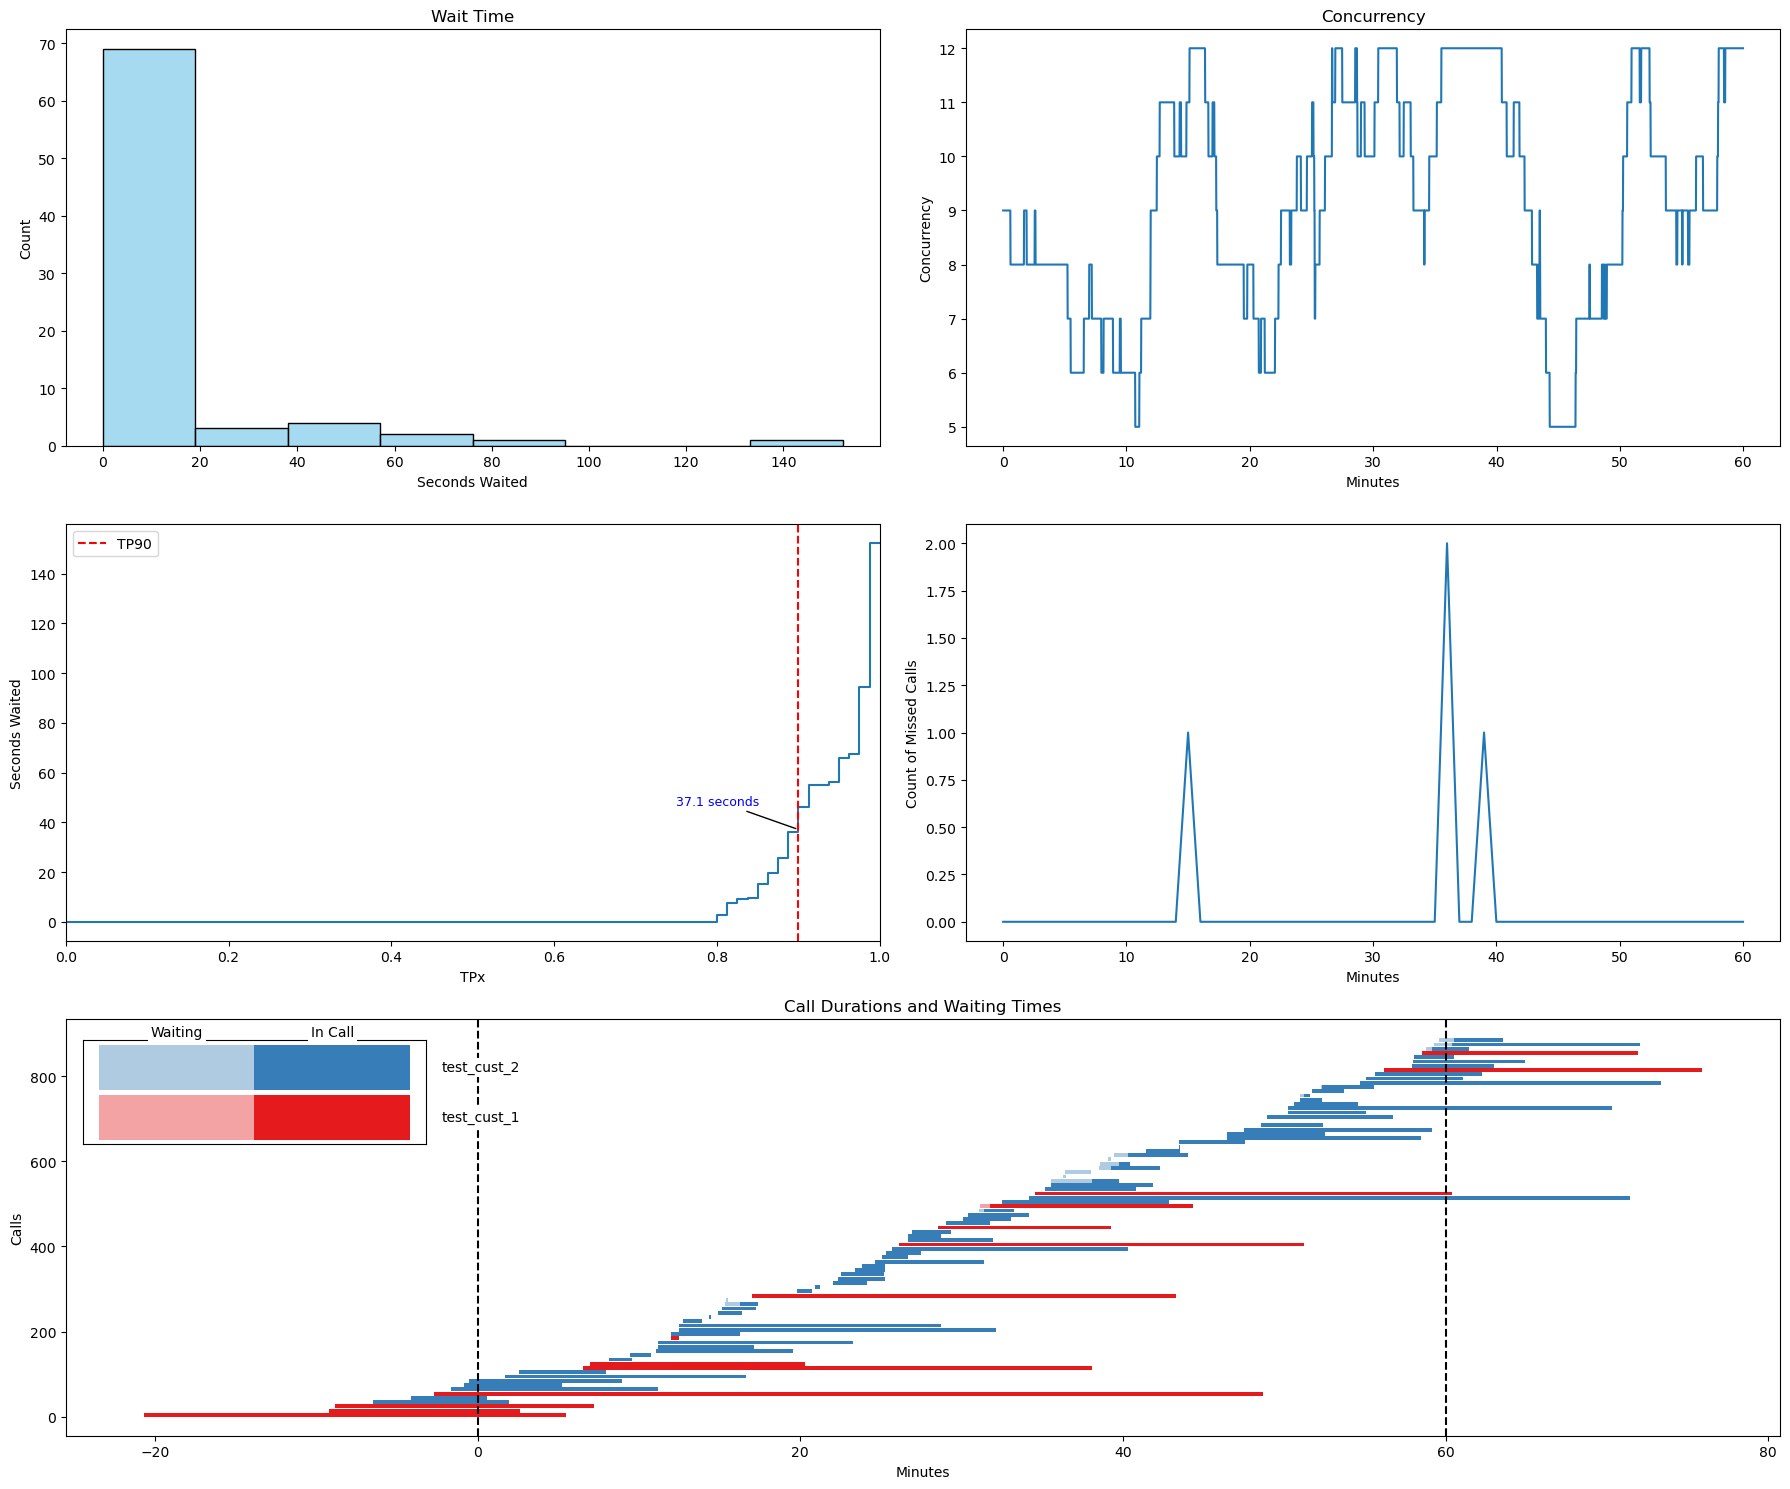

In [106]:
#this can be done with theoretical customers, using generalized distributions

test_cust_1 = Customer('test_cust_1',avg_time_between_arrivals=300, avg_service_time=1200, reneging_time=600,reneging_distribution_type='Exponential')
test_cust_2 = Customer('test_cust_2',avg_time_between_arrivals=60,avg_service_time=300, reneging_time=90,reneging_distribution_type='Exponential')

cust_list = [test_cust_1, test_cust_2]
# schedule = [[1,10],[2,20],[3,40],[1,60]]
schedule = 12

theoretical_customer_simulation = standard_concurrency_sim(cust_list, number_of_servers=schedule,simulation_window=3600,plot_units='minutes')
# records = simulation.get_all_records()
# pd.DataFrame(records).to_csv('records_copy.csv')
# records

In [107]:
"""in order to simulate data from real customers, we will read the data in from a csv 
expected columns: 
   - request_timestamp
   - pick_timestamp
   - end_timestamp (end timestamp is assumed to be hangup, i.e., end of call if successful, or cancellation of call if not picked up)
   - status ('END', 'CANCEL')
   - call_type (this is considered a 'customer' by Ciw, but can be any designation of call types. For best results, any groups of calls with distinctly different distributions of call frequency, service times, willingness to wait should be their own call type)
Separate them out into their own dataframes to be used in creating the customer objects"""

# original_df = pd.read_csv('_select_ft_request_time_as_ft_req_time_figure_out_time_between_t_202405052157.csv', encoding='utf-8')
original_df = pd.read_csv('example_historical_customer_data.csv', encoding='utf-8')
print(f"original_df: {original_df.shape}")

fill_null_with_distribution(original_df) #see note in function—avoid using this if possible
print(f'shape after: {original_df.shape}')

#this contains all current call types
cust_1_df = original_df[original_df['call_category']=='example_customer_1'].copy().reset_index(drop=True)
print(f'cust_1 shape: {cust_1_df.shape}')
cust_2_df = original_df[original_df['call_category']=='example_customer_2'].copy().reset_index(drop=True)
print(f'cust_2 shape: {cust_2_df.shape}')
cust_3_df = original_df[original_df['call_category']=='example_customer_3'].copy().reset_index(drop=True)
print(f'cust_3 shape: {cust_3_df.shape}')
cust_4_df = original_df[original_df['call_category']=='example_customer_4'].copy().reset_index(drop=True)
print(f'cust_4 shape: {cust_4_df.shape}')
cust_5_df = original_df[original_df['call_category']=='example_customer_5'].copy().reset_index(drop=True)
print(f'cust_5 shape: {cust_5_df.shape}')


original_df: (2022, 7)
shape after: (2022, 7)
cust_1 shape: (210, 7)
cust_2 shape: (780, 7)
cust_3 shape: (635, 7)
cust_4 shape: (233, 7)
cust_5 shape: (164, 7)


In [108]:
#creating the historical data simulation (Note: simulations can run with Customer and CustomerEmpirical objects in the same simulation. This can be useful if you expect to bring on a new customer/call type, for example, overseas expansion)
#creating these customers also allows us to simulate future simulations based on their previous behavior (NOTE: this is broken right now)

#create individual customer types for the simulation using our customer dataframes
cust_1 = CustomerEmpirical('cust_1',cust_1_df,priority=2)
cust_2 = CustomerEmpirical('cust_2', cust_2_df, distribution_preference='historical', priority=0)
cust_3 = CustomerEmpirical('cust_3', cust_3_df, priority=2)
cust_4 = CustomerEmpirical('cust_4', cust_4_df, priority=2)
cust_5 = CustomerEmpirical('cust_5', cust_5_df, priority=1)

getting historical reneging distribution for cust_1
distribution for cust_1 created using 962 samples
getting historical reneging distribution for cust_2
distribution for cust_2 created using 998 samples
getting historical reneging distribution for cust_3
distribution for cust_3 created using 989 samples
getting historical reneging distribution for cust_4
distribution for cust_4 created using 998 samples
getting historical reneging distribution for cust_5
distribution for cust_5 created using 898 samples


agent schedule created


100%|██████████| 100800.0/100800 [00:00<00:00, 550503.83it/s]


Simulation complete. Calculating...


Summary
utilization: 0.722
TP90: 81.9
average wait time: 23.2
missed calls: 319

call count in window: 2008
simulation window length: 86400
buffer ratio: 0.083
buffer length (per side): 7200
full simulation length: 100800


Plotting results...


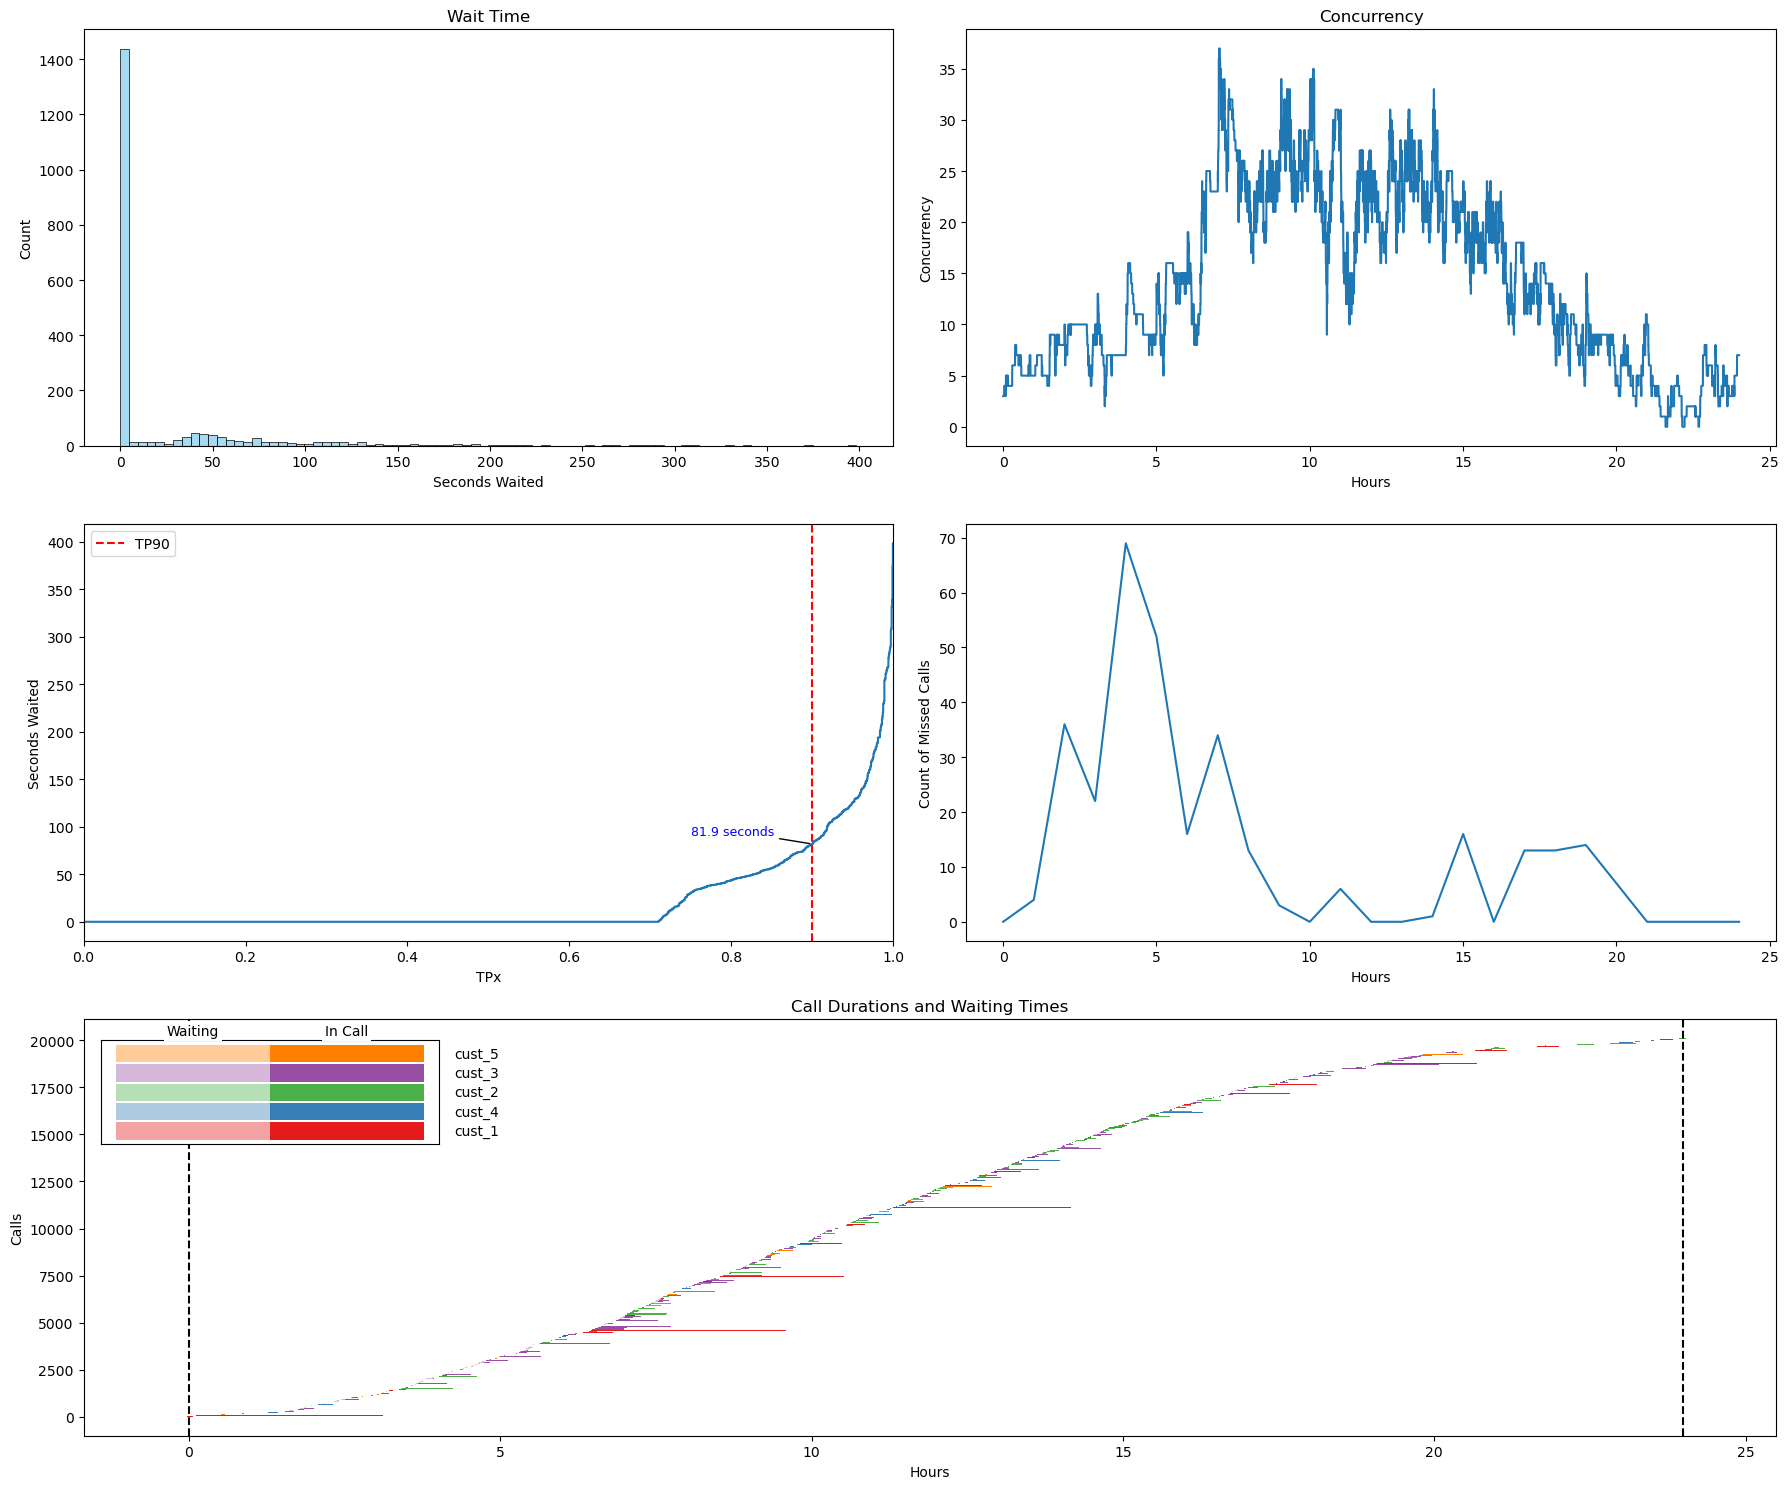

In [109]:
cust_list = [cust_1,cust_2,cust_3,cust_4,cust_5]

#different schedules that could be used
forecast_schedule = [[6,3600],[6,7200],[7,10800],[8,14400],[8,18000],[15,21600],[20,25200],[23,28800],[23,32400],[26,36000],[27,39600],[26,43200],[24,46800],[24,50400],[22,54000],[19,57600],[16,61200],[14,64800],[13,68400],[12,72000],[11,75600],[10,79200],[8,82800],[6,86400]]
agents_scheduled = [[7,3600],[6,7200],[7,10800],[7,14400],[9,18000],[15,21600],[23,25200],[24,28800],[24,32400],[26,36000],[27,39600],[25,43200],[27,46800],[25,50400],[21,54000],[20,57600],[15,61200],[13,64800],[11,68400],[8,72000],[11,75600],[9,79200],[8,82800],[6,86400]]
agents_helped = [[7,3600],[6,7200],[7,10800],[12,14400],[9,18000],[18,21600],[26,25200],[24,28800],[24,32400],[26,36000],[27,39600],[25,43200],[27,46800],[25,50400],[21,54000],[20,57600],[15,61200],[13,64800],[11,68400],[8,72000],[11,75600],[9,79200],[8,82800],[6,86400]]
infinite_schedule = 300

#creating and running the simulation happens here
simulation = standard_concurrency_sim(cust_list, number_of_servers=agents_scheduled,simulation_window=3600*24, buffer_ratio=2/24,plot_units='hours', schedule_units='seconds')

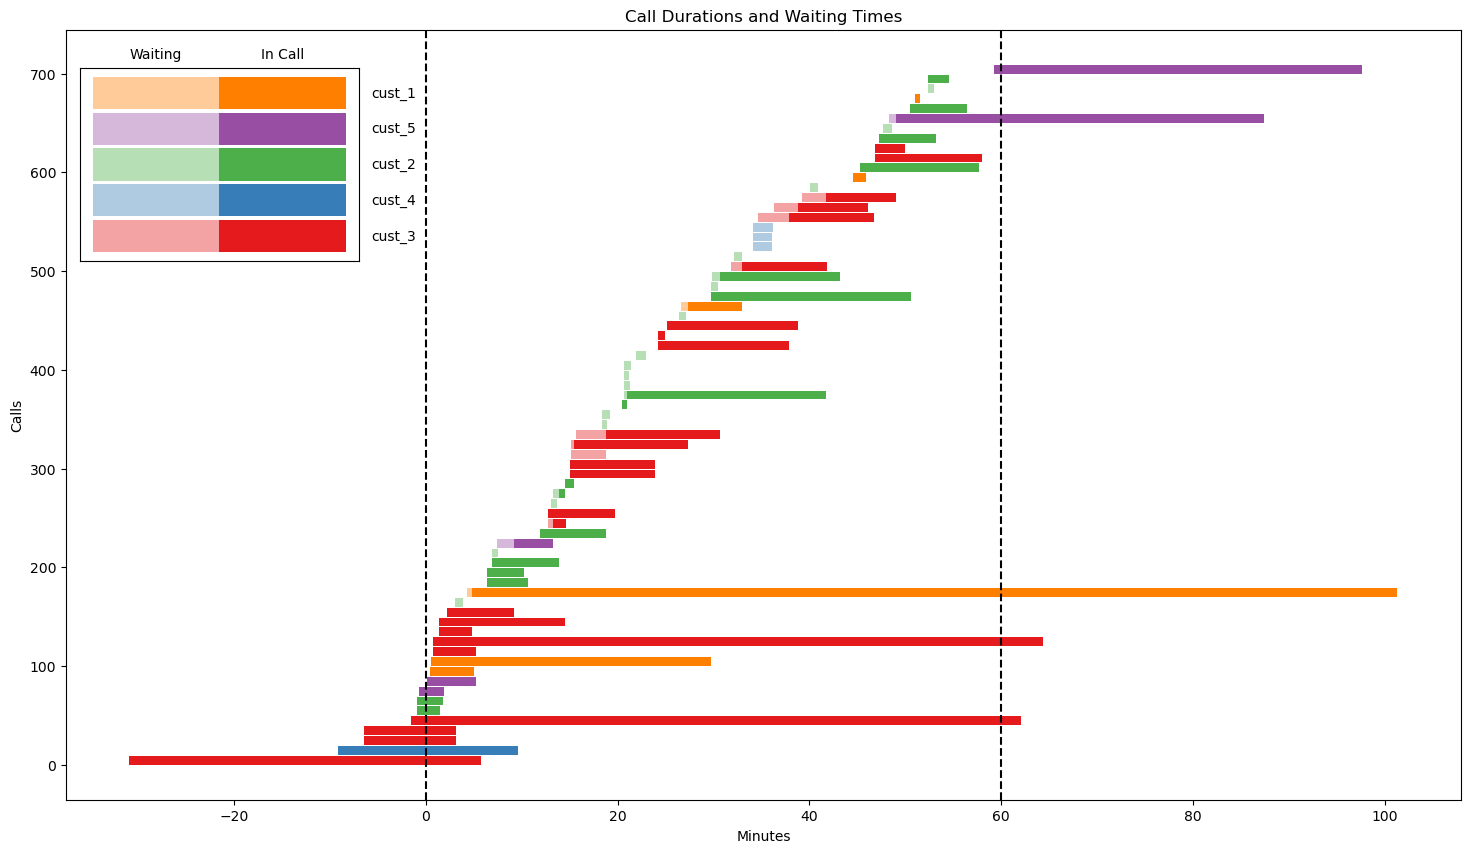

In [110]:
#After running the simulation, you can check different subsets of time and customer type
df = simulation['full_records']
start = simulation['simulation_window_start']
end = simulation['simulation_window_end']

#specific times (19:00 - 20:00)
start = simulation['simulation_window_start'] + 3600*19
end = simulation['simulation_window_start'] + 3600*20

time_sorted = calculate_waterfall(df, start, end, plot_units='minutes')

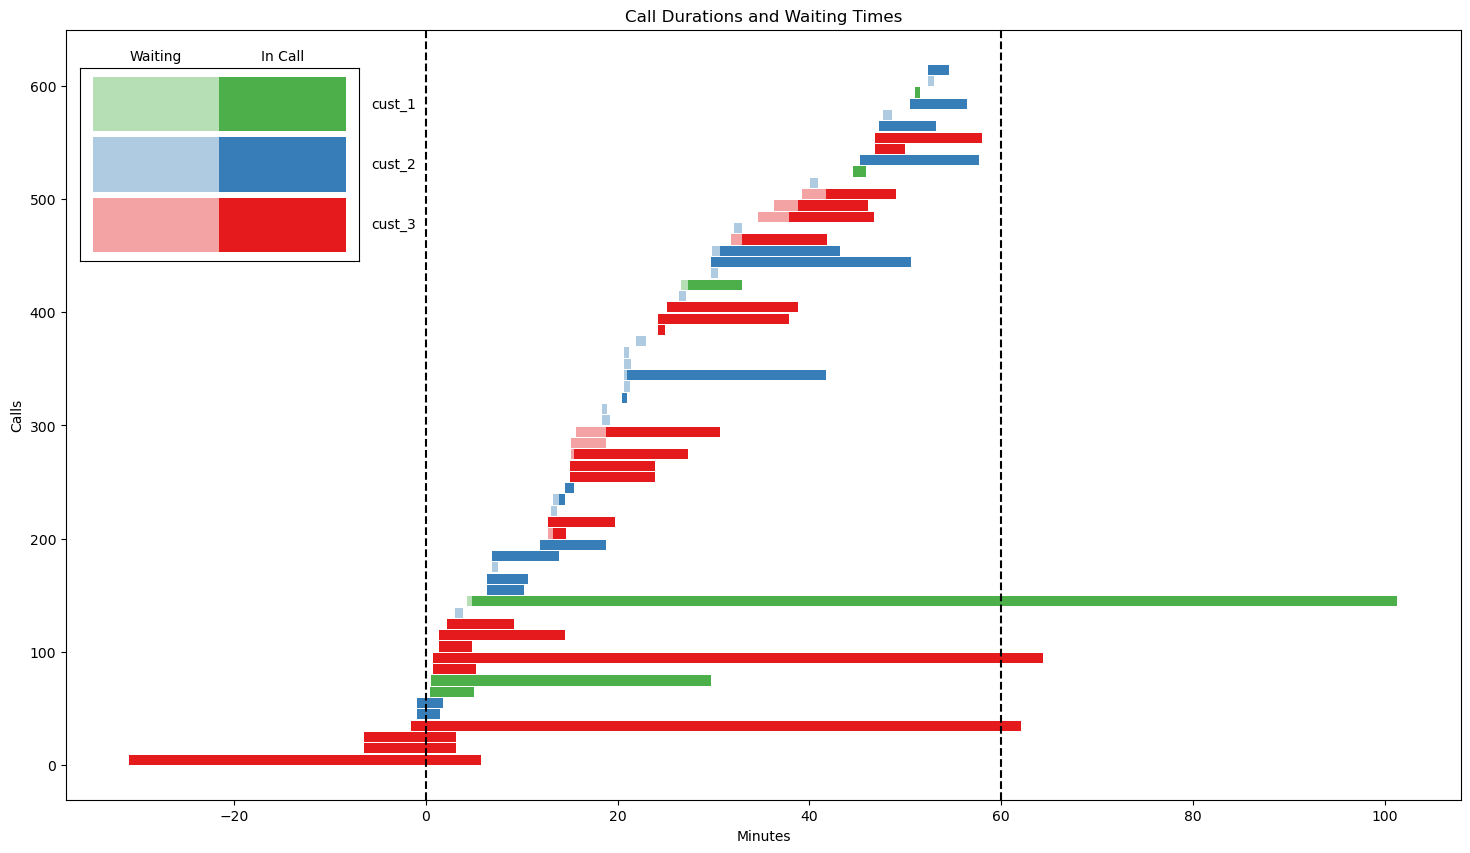

In [111]:
#This is a subset call types
df = simulation['full_records']
start = simulation['simulation_window_start']
end = simulation['simulation_window_end']

#specific times
start = simulation['simulation_window_start'] + 3600*19
end = simulation['simulation_window_start'] + 3600*20
# start = simulation['simulation_window_start']
# end = simulation['simulation_window_start']


call_list= ['cust_1','cust_2','cust_3']
call_type_sorted = calculate_waterfall(df, start, end, call_type=call_list,order_by_type=False,plot_units='minutes')

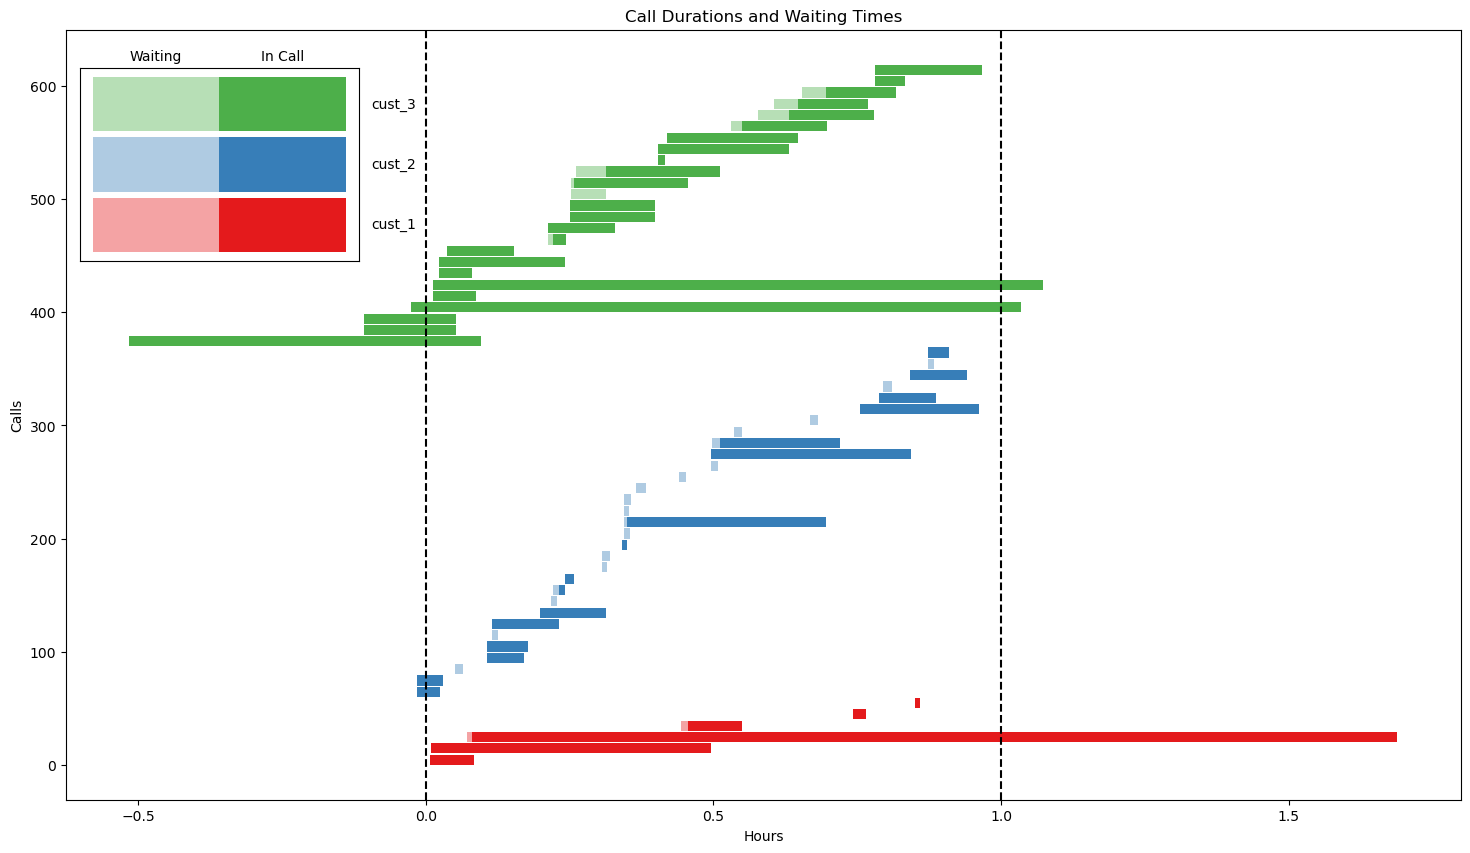

In [112]:
#Same subset, grouped by call type, in hours
df = simulation['full_records']
start = simulation['simulation_window_start']
end = simulation['simulation_window_end']

#specific times
start = simulation['simulation_window_start'] + 3600*19
end = simulation['simulation_window_start'] + 3600*20
# start = simulation['simulation_window_start']
# end = simulation['simulation_window_start']


call_list= ['cust_1','cust_2','cust_3']
call_type_sorted = calculate_waterfall(df, start, end, call_type=call_list,order_by_type=True,plot_units='hours')